In [1]:
import io
import os
import xml.etree.ElementTree as et 
import xmltodict
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\MiKTeX 2.9\\miktex\\bin\\x64\\'
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\gs\\gs9.52\\bin\\'
matplotlib.rcParams['text.usetex'] = True

# Get data

COVID-19 Open Research Dataset (CORD-19). 2020. Version 2020-08-04. Retrieved from https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html. Accessed 2020-08-04. doi:10.5281/zenodo.3715505

The query used by the authors is as follows:

    "COVID-19"[All Fields] OR ("coronavirus"[MeSH Terms] OR "coronavirus"[All Fields]) OR "Corona virus"[All Fields] OR "2019-nCoV"[All Fields] OR "SARS-CoV"[All Fields] OR "MERS-CoV"[All Fields] OR "Severe Acute Respiratory Syndrome"[All Fields] OR "Middle East Respiratory Syndrome"[All Fields]

In [2]:
cord19 = pd.read_csv("https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/latest/metadata.csv", low_memory=False) # last retrieved: 2020-05-01
cord19.shape

(207595, 19)

In [3]:
cord19.rename(columns = {'cord_uid'      :'id', 
                          'publish_time' :'published', 
                          'abstract'     :'summary', 
                          'authors'      :'author',  
                          'source_x'     :'source'}, inplace=True)

# Extract mentions of individual ArXiv sources
cord19['source'] = cord19['source'].str.lower()
cord19['medrxiv'] = cord19['source'].str.contains('medrxiv')
cord19['arxiv'  ] = cord19['source'].str.contains('arxiv')
cord19['biorxiv'] = cord19['source'].str.contains('biorxiv')

# Keep only articles with title and summary, and only articles published in 2019 or 2020
cord19.dropna(subset=['title', 'summary'], how='all', inplace=True) 
cord19['published'] = pd.to_datetime(cord19['published'])
cord19 = cord19[cord19.published.dt.year.isin([2019,2020])].copy()

cord19.shape

(125428, 22)

## Extract AI papers

In [4]:
cord19['paper_type'] = 'Not AI'
cord19['paper_type'] = np.where(cord19['title'  ].astype(str).str.lower().str.contains("(machine learning|artificial intelligence|deep learning|neural network)"), 
                                'AI', 
                                cord19['paper_type'])
cord19['paper_type'] = np.where(cord19['summary'].astype(str).str.lower().str.contains("(machine learning|artificial intelligence|deep learning|neural network)"), 
                                'AI', 
                                cord19['paper_type'])

## Remove duplicates

In [5]:
# Naively, on ID
cord19.drop_duplicates(subset=['id'], inplace=True)

# On IDs pulled from other sources
unique_identifiers = ['sha', 'doi',  'pubmed_id',  'url', 's2_id', 'arxiv_id', 'pmcid', 'who_covidence_id']

for u in unique_identifiers:
    
    # Get the maximum value count of a single ID
    print("Variable:      ", u, "\nMax count:", cord19[u].value_counts().max())
    
    # Figure out how many true duplicates there are (ignoring NAN counted as duplicate)
    missing    = cord19[u].isna().value_counts().loc[True]
    duplicated = cord19[u].duplicated(keep=False).value_counts().loc[True]

    print("True duplicates", duplicated - missing)
    
    # Count how many records drop
    shape_before = cord19.shape[0]    
    cord19 = cord19[~(~cord19[u].isna() & cord19[u].duplicated(keep=False))].copy()
    shape_after = cord19.shape[0]
    
    print("N dropped      ", shape_before - shape_after, "\n")
    

Variable:       sha 
Max count: 3
True duplicates 7
N dropped       7 

Variable:       doi 
Max count: 2
True duplicates 2
N dropped       2 

Variable:       pubmed_id 
Max count: 3
True duplicates 48
N dropped       48 

Variable:       url 
Max count: 1
True duplicates 0
N dropped       0 

Variable:       s2_id 
Max count: 20
True duplicates 80057
N dropped       80057 

Variable:       arxiv_id 
Max count: 1
True duplicates 0
N dropped       0 

Variable:       pmcid 
Max count: 1
True duplicates 0
N dropped       0 

Variable:       who_covidence_id 
Max count: 1
True duplicates 0
N dropped       0 



## Save all papers

In [6]:
cord19[cord19.paper_type=="AI"].to_csv("list_of_papers.csv", encoding='utf-8-sig')
cord19[cord19.paper_type=="AI"].shape

(1375, 23)

# Analyze

## Total counts

In [7]:
# How many AI papers in our time window?
cord19[cord19.paper_type=="AI"].set_index("published").loc['2020-01-01':'2020-08-01'].count()['title']

1305

In [8]:
# How many total COVID papers in our time window?
cord19.set_index("published").loc['2020-01-01':'2020-08-01'].count()['title']

36292

In [9]:
# TODO: need to handle multiple reporting in the plot below
cord19.source.value_counts()

pmc                                   10981
medline                                5493
medrxiv                                5128
medline; pmc                           4375
who                                    3933
arxiv                                  2252
elsevier; pmc; who                     2181
elsevier; medline; pmc                 1916
pmc; who                               1560
biorxiv                                1425
medline; pmc; who                      1388
elsevier; pmc                          1187
elsevier; medline; pmc; who             558
medline; who                            507
biorxiv; medrxiv                        197
medrxiv; medline; pmc                   192
elsevier                                144
medrxiv; medline                        115
biorxiv; medline; pmc                    77
biorxiv; medline                         58
biorxiv; medline; pmc; who               48
biorxiv; medline; who                    23
medrxiv; medline; pmc; who      

## Plot

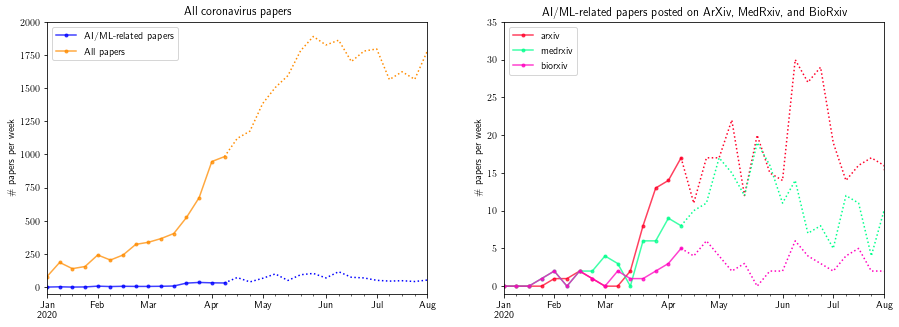

In [10]:
fig, ax = plt.subplots(1,2, figsize=[15,5])

# Note: we start from 2 January because it looks like articles with missing date get assigned to Jan 1
plot_df = cord19.set_index('published').loc['2020-01-02':'2020-08-04'].reset_index()

###############################
# Plot all papers (left panel)
###############################

plot_df1 = plot_df.groupby([plot_df.published.dt.to_period('W'), 
                            plot_df.paper_type]).count()['id'].unstack(level=['paper_type']).fillna(0)

plot_df1['All papers'] = plot_df1['AI'] + plot_df1['Not AI']


plot_df1[['AI', 'All papers']].loc['2020-01-02':'2020-04-10'].plot(ax=ax[0],  legend=True,  alpha=0.75, color=['blue', 'darkorange'], marker=".")
plot_df1[['AI', 'All papers']].loc['2020-04-10':].plot(ax=ax[0],  legend=True,  alpha=1, color=['blue', 'darkorange'], linestyle=":")


ax[0].set_xlabel("")
ax[0].set_ylabel("$\#$ papers per week")
ax[0].set_title("All coronavirus papers") #CORD-19 papers + ArXiv papers mentioning covid/coronavirus/sars-cov-2")
ax[0].legend(["AI/ML-related papers", "All papers"])

##################################
# Plot ML/AI papers (right panel)
##################################

plot_df2 = plot_df.groupby([plot_df.published.dt.to_period('W'),
                            plot_df.paper_type]).sum()[['arxiv', 'medrxiv', 'biorxiv']].unstack(level=['paper_type']).fillna(0)

plot_df2 = plot_df2.xs("AI", level="paper_type", axis=1).fillna(0)
plot_df2[['arxiv', 'medrxiv', 'biorxiv']].loc['2020-01-02':'2020-04-10'].plot(alpha=0.75, ax=ax[1], cmap='gist_rainbow', marker=".", legend=True)
plot_df2[['arxiv', 'medrxiv', 'biorxiv']].loc['2020-04-10':].plot(alpha=1, ax=ax[1], cmap='gist_rainbow', linestyle=":",  legend=False)

ax[1].set_xlabel("")
ax[1].set_ylabel("$\#$ papers per week")
ax[1].set_title("AI/ML-related papers posted on ArXiv, MedRxiv, and BioRxiv") 


##################################
# Polish and save plot
##################################

ax[0].set_xlim('2020-01-02', '2020-08-01')
ax[1].set_xlim('2020-01-02', '2020-08-01')
ax[0].set_ylim(-50, 2000)
ax[1].set_ylim(-1, 35)

plt.savefig("automated_lit_review.pdf", dpi=100, bbox_inches="tight")
plt.savefig("automated_lit_review.png", dpi=100, bbox_inches="tight")

In [11]:
plot_df1['All papers'].cumsum()

published
2019-12-30/2020-01-05       79.0
2020-01-06/2020-01-12      265.0
2020-01-13/2020-01-19      404.0
2020-01-20/2020-01-26      559.0
2020-01-27/2020-02-02      801.0
2020-02-03/2020-02-09     1005.0
2020-02-10/2020-02-16     1247.0
2020-02-17/2020-02-23     1569.0
2020-02-24/2020-03-01     1907.0
2020-03-02/2020-03-08     2273.0
2020-03-09/2020-03-15     2677.0
2020-03-16/2020-03-22     3202.0
2020-03-23/2020-03-29     3877.0
2020-03-30/2020-04-05     4824.0
2020-04-06/2020-04-12     5808.0
2020-04-13/2020-04-19     6929.0
2020-04-20/2020-04-26     8105.0
2020-04-27/2020-05-03     9488.0
2020-05-04/2020-05-10    10993.0
2020-05-11/2020-05-17    12588.0
2020-05-18/2020-05-24    14371.0
2020-05-25/2020-05-31    16261.0
2020-06-01/2020-06-07    18087.0
2020-06-08/2020-06-14    19949.0
2020-06-15/2020-06-21    21650.0
2020-06-22/2020-06-28    23430.0
2020-06-29/2020-07-05    25226.0
2020-07-06/2020-07-12    26791.0
2020-07-13/2020-07-19    28415.0
2020-07-20/2020-07-26    29982.0


In [12]:
plot_df1['AI'].cumsum()

published
2019-12-30/2020-01-05       0.0
2020-01-06/2020-01-12       2.0
2020-01-13/2020-01-19       2.0
2020-01-20/2020-01-26       3.0
2020-01-27/2020-02-02      10.0
2020-02-03/2020-02-09      14.0
2020-02-10/2020-02-16      20.0
2020-02-17/2020-02-23      25.0
2020-02-24/2020-03-01      30.0
2020-03-02/2020-03-08      36.0
2020-03-09/2020-03-15      44.0
2020-03-16/2020-03-22      74.0
2020-03-23/2020-03-29     109.0
2020-03-30/2020-04-05     141.0
2020-04-06/2020-04-12     172.0
2020-04-13/2020-04-19     244.0
2020-04-20/2020-04-26     283.0
2020-04-27/2020-05-03     349.0
2020-05-04/2020-05-10     448.0
2020-05-11/2020-05-17     498.0
2020-05-18/2020-05-24     591.0
2020-05-25/2020-05-31     694.0
2020-06-01/2020-06-07     763.0
2020-06-08/2020-06-14     879.0
2020-06-15/2020-06-21     953.0
2020-06-22/2020-06-28    1022.0
2020-06-29/2020-07-05    1073.0
2020-07-06/2020-07-12    1118.0
2020-07-13/2020-07-19    1166.0
2020-07-20/2020-07-26    1208.0
2020-07-27/2020-08-02    1261.